#Introduction

This notebook is a easy guide for training and testing of anomaly detection based on MVTec https://github.com/AdneneBoumessouer/MVTec-Anomaly-Detection.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1IzBqUvTSTYzoa3gG3_gLh3QQKbylrQNf#scrollTo=5tVeHtQDhzed)

In [ ]:
!pip3 install ktrain

###Link Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive

#Clone Repo

In [ ]:
!git clone https://github.com/MNaseerSubhani/MVTec-Anomaly-Detection-For-Industry.git

Cloning into 'MVTec-Anomaly-Detection-For-Industry'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 45 (delta 8), reused 30 (delta 1), pack-reused 0
Unpacking objects: 100% (45/45), done.


In [ ]:
%cd /content/drive/MyDrive/MVTec-Anomaly-Detection-For-Industry

###Update Submodule : 


In [ ]:
!git submodule init
!git submodule update

#Dataset 

### Directory Structure using your own dataset

To train with your own dataset, you need to have a comparable directory structure. For example:

In [ ]:
#MVTec-Anomaly-Detection
      #data
        #├── class1
        # │   ├── test
        # │   │   ├── good
        # │   │   ├── defect
        # │   └── train
        # │       └── good
        # ├── class2
        # │   ├── test
        # │   │   ├── good
        # │   │   ├── defect
        # │   └── train
        # │       └── good
        # ...


#Training 

In [ ]:
# During training, the CAE trains exclusively on defect-free images and learns to reconstruct (predict) defect-free training samples.

# usage: train.py [-h] -d [-a] [-c] [-l] [-b] [-i]

# optional arguments:

# -h, --help show this help message and exit

# -d , --input-dir directory containing training images

# -a , --architecture architecture of the model to use for training: 'mvtecCAE', 'baselineCAE', 'inceptionCAE' or 'resnetCAE'

# -c , --color color mode for preprocessing images before training: 'rgb' or 'grayscale'

# -l , --loss loss function to use for training: 'mssim', 'ssim' or 'l2'

# -b , --batch batch size to use for training

# -i, --inspect generate inspection plots after training

# Example usage:

# python3 train.py -d mvtec/capsule -a mvtecCAE -b 8 -l ssim -c grayscale


In [ ]:
!python3 ./MVTec-Anomaly-Detection/train.py -d data/class -a baselineCAE -b 16 -l l2 -c grayscale

#Finetune 

In [ ]:
# This script used a subset of defect-free training images and a subset of both defect and defect-free test images to determine good values for minimum defect area and threshold pair of parameters that will be used during testing for classification and segmentation.

# usage: finetune.py [-h] -p [-m] [-t]

# optional arguments: -h, --help show this help message and exit

# -p , --path path to saved model

# -m , --method method for generating resmaps: 'ssim' or 'l2'

# -t , --dtype datatype for processing resmaps: 'float64' or 'uint8'

In [ ]:
!python3 ./MVTec-Anomaly-Detection/finetune.py -p path/to/model -m ssim -t float64

#Testing

In [ ]:
# This script classifies test images using the minimum defect area and threshold previously approximated at the finetuning step.

# usage: test.py [-h] -p [-s]

# optional arguments: -h, --help show this help message and exit

# -p , --path path to saved model

# -s, --save save segmented images

In [ ]:
!python3 ./MVTec-Anomaly-Detection/test.py -p path/to/model

#Validate

In [ ]:
%cd ./MVTec-Anomaly-Detection
from skimage.measure import compare_ssim
import sys
import os
import argparse
from pathlib import Path
import shlex
import time
import json
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt     
from processing import utils
from processing import postprocessing
from processing.preprocessing import Preprocessor
from processing.preprocessing import get_preprocessing_function
from processing.postprocessing import label_images
from processing.utils import printProgressBar
from skimage.util import img_as_ubyte
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import glob
import cv2
import seaborn as sn
import seaborn as sns
import matplotlib.pyplot as plt    
import pandas as pd
import logging
from sklearn.metrics import confusion_matrix
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
%cd ..

In [ ]:
def Test(args, th):
  model_path = args.path
  # load model and info
  model, info, _ = utils.load_model_HDF5(model_path)
  # set parameters
  input_directory = info["data"]["input_directory"]
  architecture = info["model"]["architecture"]
  loss = info["model"]["loss"]
  rescale = info["preprocessing"]["rescale"]
  shape = info["preprocessing"]["shape"]
  color_mode = info["preprocessing"]["color_mode"]
  vmin = info["preprocessing"]["vmin"]
  vmax = info["preprocessing"]["vmax"]
  nb_validation_images = info["data"]["nb_validation_images"]

  preprocessing_function = get_preprocessing_function(architecture)
  # # initialize preprocessor
  preprocessor = Preprocessor(
      input_directory=input_directory,
      rescale=rescale,
      shape=shape,
      color_mode=color_mode,
      preprocessing_function=preprocessing_function,
  )

  tst_img_list = [glob.glob(args.tst_pth + "/good/*.jpeg"), glob.glob(args.tst_pth + "/defect/*.jpeg")]
  tst_lbl_list = [list (np.ones(len(tst_img_list[0]))), list (np.zeros(len(tst_img_list[1])))]
  tst_prd_list = [list (np.ones(len(tst_img_list[0]))), list (np.zeros(len(tst_img_list[1])))]

  tst_img_list = tst_img_list[0] + tst_img_list[1]
  tst_lbl_list = tst_lbl_list[0] + tst_lbl_list[1]
  tst_prd_list = tst_prd_list[0] + tst_prd_list[1]
  
  for i,img_nm in enumerate(tst_img_list):
    img = preprocessor.get_test_image(img_nm)
    imgs_test_pred = model.predict(img)
    map = np.sqrt((imgs_test_pred - img)**2)
    # (score, diff ) = compare_ssim(imgs_test_pred.reshape(128,128)*255, img.reshape(128,128)*255, full=True)
    # map = map/np.max(map)
    kernel = np.ones((20, 20), np.uint8)
    map = cv2.morphologyEx(map[0], cv2.MORPH_CLOSE, kernel)
  #   print("--- %s seconds ---" % (time.time() - start_time))
    map = np.where(map> th,1,0)
    # m_map = np.mean(map)
    # plt.imshow(map.reshape(128,128), cmap='gray')
    # plt.show()
    cnt_1 = np.count_nonzero(map)
    # print(cnt_1, f" :",tst_img_list[i])
    if cnt_1 > 1:
      tst_prd_list[i] = 0
    else:
      tst_prd_list[i] = 1

# confusion matrix
  matrix = confusion_matrix(tst_lbl_list,tst_prd_list, labels=[1,0])
  print('Classification report : \n',matrix)
  return matrix


In [ ]:

def inference(args):
    # parse arguments
    model_path = args.path
    # ============= LOAD MODEL AND PREPROCESSING CONFIGURATION ================
    # load model and info
    model, info, _ = utils.load_model_HDF5(model_path)
    # set parameters
    input_directory = info["data"]["input_directory"]
    architecture = info["model"]["architecture"]
    loss = info["model"]["loss"]
    rescale = info["preprocessing"]["rescale"]
    shape = info["preprocessing"]["shape"]
    color_mode = info["preprocessing"]["color_mode"]
    vmin = info["preprocessing"]["vmin"]
    vmax = info["preprocessing"]["vmax"]
    nb_validation_images = info["data"]["nb_validation_images"]

    # =================== LOAD VALIDATION PARAMETERS =========================

    # model_dir_name = os.path.basename(str(Path(model_path).parent))
    # finetune_dir = os.path.join(
    #     os.getcwd(),
    #     "results",
    #     input_directory,
    #     architecture,
    #     loss,
    #     model_dir_name,
    #     "finetuning",
    # )
    # subdirs = os.listdir(finetune_dir)
    # for subdir in subdirs:
    #     logger.info(
    #         "testing with finetuning parameters from \n{}...".format(
    #             os.path.join(finetune_dir, subdir)
    #         )
    #     )
    #     try:
    #         with open(
    #             os.path.join(finetune_dir, subdir, "finetuning_result.json"), "r"
    #         ) as read_file:
    #             validation_result = json.load(read_file)
    #     except FileNotFoundError:
    #         logger.warning("run finetune.py before testing.\nexiting script.")
    #         sys.exit()

   

    #     # ====================== PREPROCESS TEST IMAGES ==========================

    #     # get the correct preprocessing function
    preprocessing_function = get_preprocessing_function(architecture)

    # # initialize preprocessor
    preprocessor = Preprocessor(
        input_directory=input_directory,
        rescale=rescale,
        shape=shape,
        color_mode=color_mode,
        preprocessing_function=preprocessing_function,
    )

    # get test image
    img = preprocessor.get_test_image(args.img_pth)
    plt.imshow(img.reshape(512,512), cmap='gray')
    plt.show()
    #predict on test image
    start_time = time.time()

    imgs_test_pred = model.predict(img)
    map = np.sqrt((imgs_test_pred - img)**2)

    print("--- %s seconds ---" % (time.time() - start_time))

    kernel = np.ones((20, 20), np.uint8)

    map = cv2.morphologyEx(map[0], cv2.MORPH_CLOSE, kernel)

    plt.imshow(imgs_test_pred.reshape(512,512), cmap='gray')
    plt.show()

    

    (score, diff ) = compare_ssim(imgs_test_pred.reshape(512,512)*255, img.reshape(512,512)*255, full=True)
    # diff = 1 - (diff/np.max(diff) ) 
    # diff = (diff - np.mean(diff)) / np.std(diff)
    # print(np.max(diff))
    # diff = (diff * 255) 
    

    map = np.where(map> 0.4,1,0)

    plt.imshow(map.reshape(512,512), cmap='gray')
    plt.show()

    
    plt.imshow(diff, cmap = 'gray')
    plt.show()

    #     # instantiate TensorImages object
    #     tensor_test = postprocessing.TensorImages(
    #         imgs_input=imgs_test_input,
    #         imgs_pred=imgs_test_pred,
    #         vmin=vmin,
    #         vmax=vmax,
    #         method=method,
    #         dtype=dtype,
    #         filenames=filenames,
    #     )

    #     # ====================== CLASSIFICATION ==========================

    #     # retrieve ground truth
    #     y_true = get_true_classes(filenames)

    #     # predict classes on test images
    #     y_pred = predict_classes(
    #         resmaps=tensor_test.resmaps, min_area=min_area, threshold=threshold
    #     )

    #     # confusion matrix
    #     tnr, fp, fn, tpr = confusion_matrix(y_true, y_pred, normalize="true").ravel()

    #     # initialize dictionary to store test results
    #     test_result = {
    #         "min_area": min_area,
    #         "threshold": threshold,
    #         "TPR": tpr,
    #         "TNR": tnr,
    #         "score": (tpr + tnr) / 2,
    #         "method": method,
    #         "dtype": dtype,
    #     }

    #     # ====================== SAVE TEST RESULTS =========================

    #     # create directory to save test results
    #     save_dir = os.path.join(
    #         os.getcwd(),
    #         "results",
    #         input_directory,
    #         architecture,
    #         loss,
    #         model_dir_name,
    #         "test",
    #         subdir,
    #     )

    #     if not os.path.isdir(save_dir):
    #         os.makedirs(save_dir)

    #     # save test result
    #     with open(os.path.join(save_dir, "test_result.json"), "w") as json_file:
    #         json.dump(test_result, json_file, indent=4, sort_keys=False)

    #     # save classification of image files in a .txt file
    #     classification = {
    #         "filenames": filenames,
    #         "predictions": y_pred,
    #         "truth": y_true,
    #         "accurate_predictions": np.array(y_true) == np.array(y_pred),
    #     }
    #     df_clf = pd.DataFrame.from_dict(classification)
    #     with open(os.path.join(save_dir, "classification.txt"), "w") as f:
    #         f.write(
    #             "min_area = {}, threshold = {}, method = {}, dtype = {}\n\n".format(
    #                 min_area, threshold, method, dtype
    #             )
    #         )
    #         f.write(df_clf.to_string(header=True, index=True))

    #     # print classification results to console
    #     with pd.option_context("display.max_rows", None, "display.max_columns", None):
    #         print(df_clf)

    #     # save segmented resmaps
    #     #if save:
    #     save_segmented_images(tensor_test.resmaps, threshold, filenames, save_dir)

    #     # print test_results to console
    #     print("test results: {}".format(test_result))





In [ ]:
parser = argparse.ArgumentParser() 
parser.add_argument("-p",
    "--path", type=str, default= None ,required=True, metavar="", help="path to saved model"
)
parser.add_argument(
    "-i", "--img_pth", type=str, default = 'None', help="save segmented images",
)

parser.add_argument(
     "--tst_pth", type=str, default = None, help="path to test folder",
)

notebook_args = f"""
--path "path/to/model"
--img_pth "path/to/single/images/inference"
--tst_pth "path/to/test/folder"
"""
args = parser.parse_args(shlex.split(notebook_args))


In [ ]:
matr = Test(args, 0.4)

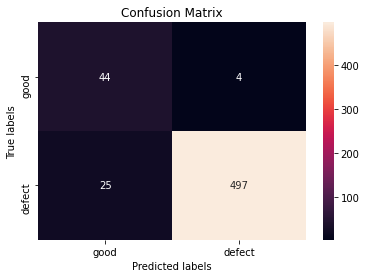

In [ ]:
ax= plt.subplot()
sns.heatmap(matr, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['good', 'defect']); ax.yaxis.set_ticklabels(['good', 'defect']);

In [ ]:
inference(args)